In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import shap

In [18]:
df = pd.read_csv('../data/loan_approval_dataset.csv')

In [5]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [19]:
df.drop('loan_id', axis=1, inplace=True)

# Data Cleaning and EDA


In [8]:
# Checking for missing values
missing_values = df.isnull().sum()
missing_values

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [9]:
# Checking for duplicate rows in dataset
df.duplicated().sum()

np.int64(0)

In [10]:
# Getting statistical summary of  dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_dependents,4269.0,2.498712e+00,1.695910e+00,0.0,1.0,3.0,4.0,5.0
income_annum,4269.0,5.059124e+06,2.806840e+06,200000.0,2700000.0,5100000.0,7500000.0,9900000.0
loan_amount,4269.0,1.513345e+07,9.043363e+06,300000.0,7700000.0,14500000.0,21500000.0,39500000.0
loan_term,4269.0,1.090045e+01,5.709187e+00,2.0,6.0,10.0,16.0,20.0
cibil_score,4269.0,5.999361e+02,1.724304e+02,300.0,453.0,600.0,748.0,900.0
residential_assets_value,4269.0,7.472617e+06,6.503637e+06,-100000.0,2200000.0,5600000.0,11300000.0,29100000.0
commercial_assets_value,4269.0,4.973155e+06,4.388966e+06,0.0,1300000.0,3700000.0,7600000.0,19400000.0
luxury_assets_value,4269.0,1.512631e+07,9.103754e+06,300000.0,7500000.0,14600000.0,21700000.0,39200000.0
bank_asset_value,4269.0,4.976692e+06,3.250185e+06,0.0,2300000.0,4600000.0,7100000.0,14700000.0


**Data Visualisation**

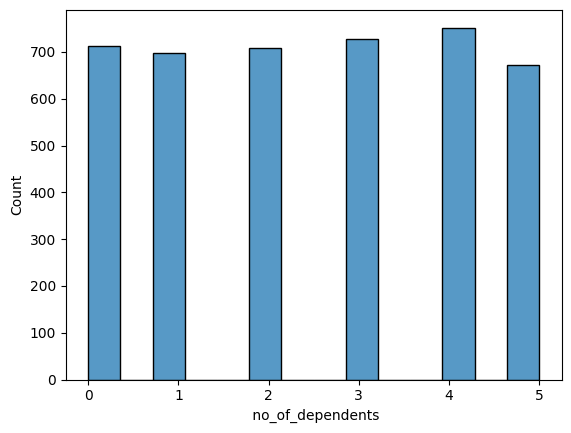

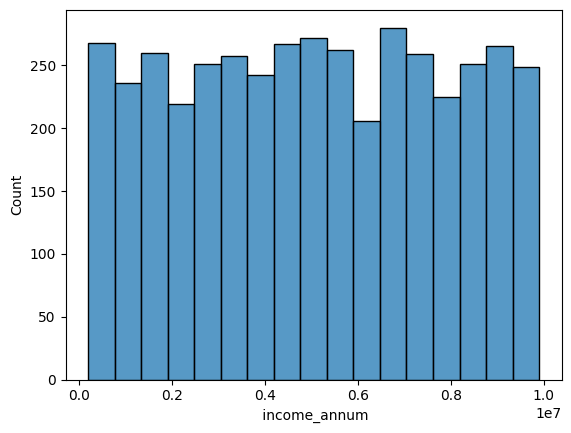

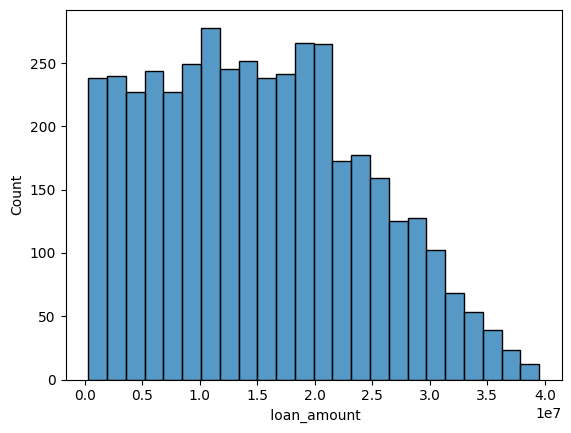

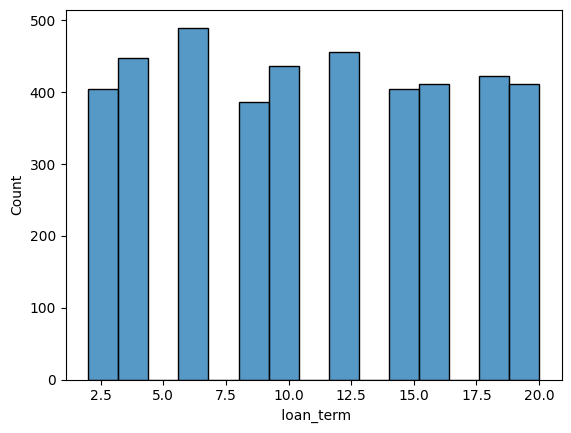

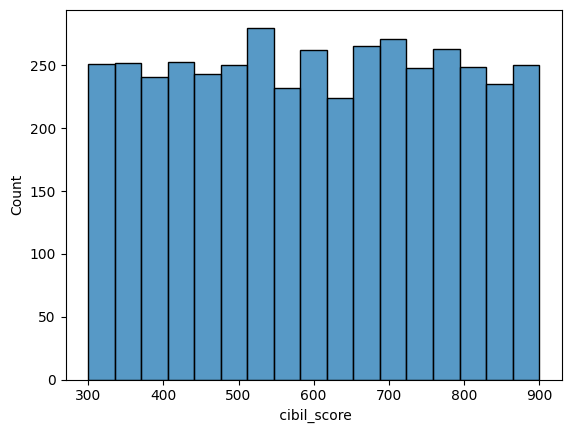

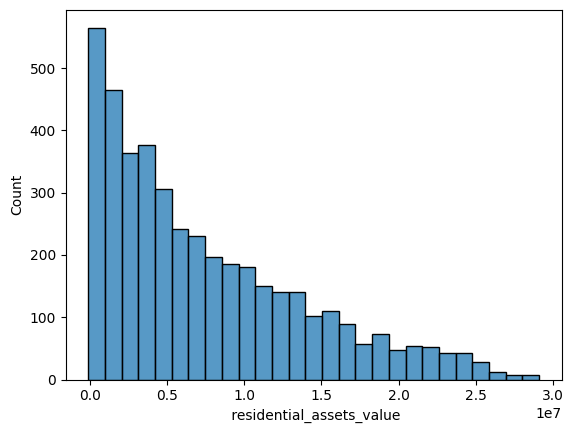

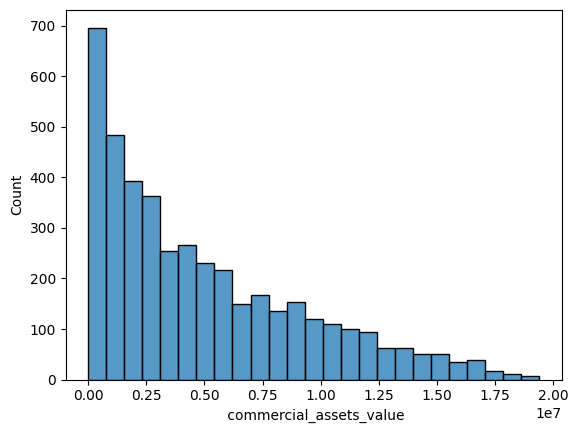

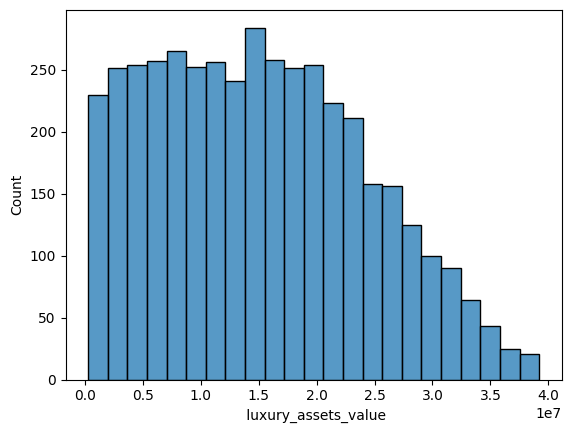

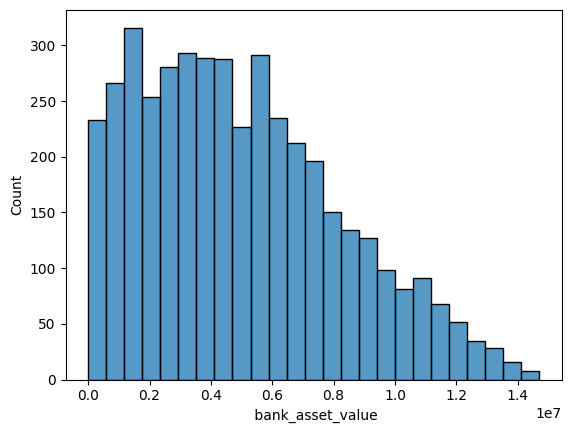

In [11]:
# Histograms
for i in df.select_dtypes(include=['number']).columns:
    sns.histplot(data=df, x=i)
    plt.show()

📌 Some of the columns are not evenly distributed. We shall deal with this by performing a log transformation

# Data Preprocessing

Updating Column name

In [20]:
df.columns = ['dependents', 'education', 'self_employed', 'annual_income', 'loan_amount', 'loan_term',
              'credit_score', 'residential_av', 'commercial_av', 'luxury_av', 'bank_av', 'loan_status']

Let us create some new features from the already existing features

In [21]:
df['income_to_loan_ratio'] = df['annual_income'] / df['loan_amount']
df['bank_assets_ratio'] = df['bank_av'] / (df['residential_av'] + df['commercial_av'] + df['luxury_av'])
df['loan_term_to_income_ratio'] = df['loan_term'] / df['annual_income']
df['credit_score_to_income_ratio'] = df['credit_score'] / df['annual_income']

Handling Categorical Variables

Objective: To convert categorical variables into numerical formats suitable for model training.

In [22]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Categorical Columns: \n{categorical_columns.tolist()}")

Categorical Columns: 
['education', 'self_employed', 'loan_status']


In [23]:
# Cycle that captures unique values ​​for each category column
for i in categorical_columns:
    print(i, df[i].unique(), df[i].nunique())

education [' Graduate' ' Not Graduate'] 2
self_employed [' No' ' Yes'] 2
loan_status [' Approved' ' Rejected'] 2


One-Hot Encoding

In [24]:
# Applying One-Hot Encoding to nominal categorical variables
df = pd.get_dummies(df, columns=categorical_columns )

# Show the first few rows of the modified dataframe
df.head()

,dependents,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,income_to_loan_ratio,bank_assets_ratio,loan_term_to_income_ratio,credit_score_to_income_ratio,education_ Graduate,education_ Not Graduate,self_employed_ No,self_employed_ Yes,loan_status_ Approved,loan_status_ Rejected
0,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,0.321070,0.187354,1.250000e-06,0.000081,True,False,True,False,True,False
1,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0.336066,0.240876,1.951220e-06,0.000102,False,True,False,True,False,True
2,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0.306397,0.285078,2.197802e-06,0.000056,True,False,True,False,False,True
3,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0.267101,0.176339,9.756098e-07,0.000057,True,False,True,False,False,True
4,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0.404959,0.100000,2.040816e-06,0.000039,False,True,False,True,False,True


In [25]:
# Removing redundant columns
df.drop(columns=['loan_status_ Rejected', 'education_ Not Graduate', 'self_employed_ No' ], axis=1, inplace=True)

In [26]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

Index(['dependents', 'annual_income', 'loan_amount', 'loan_term',
       'credit_score', 'residential_av', 'commercial_av', 'luxury_av',
       'bank_av', 'income_to_loan_ratio', 'bank_assets_ratio',
       'loan_term_to_income_ratio', 'credit_score_to_income_ratio',
       'education__graduate', 'self_employed__yes', 'loan_status__approved'],
      dtype='object')

In [27]:
df['loan_status__approved'] = df['loan_status__approved'].astype(int)

In [28]:
# Change the target name
df.rename(columns={"loan_status__approved": "loan_status"}, inplace=True)

📝 Plotting a correlation heatmap so as to see which features correlate with Loan Status

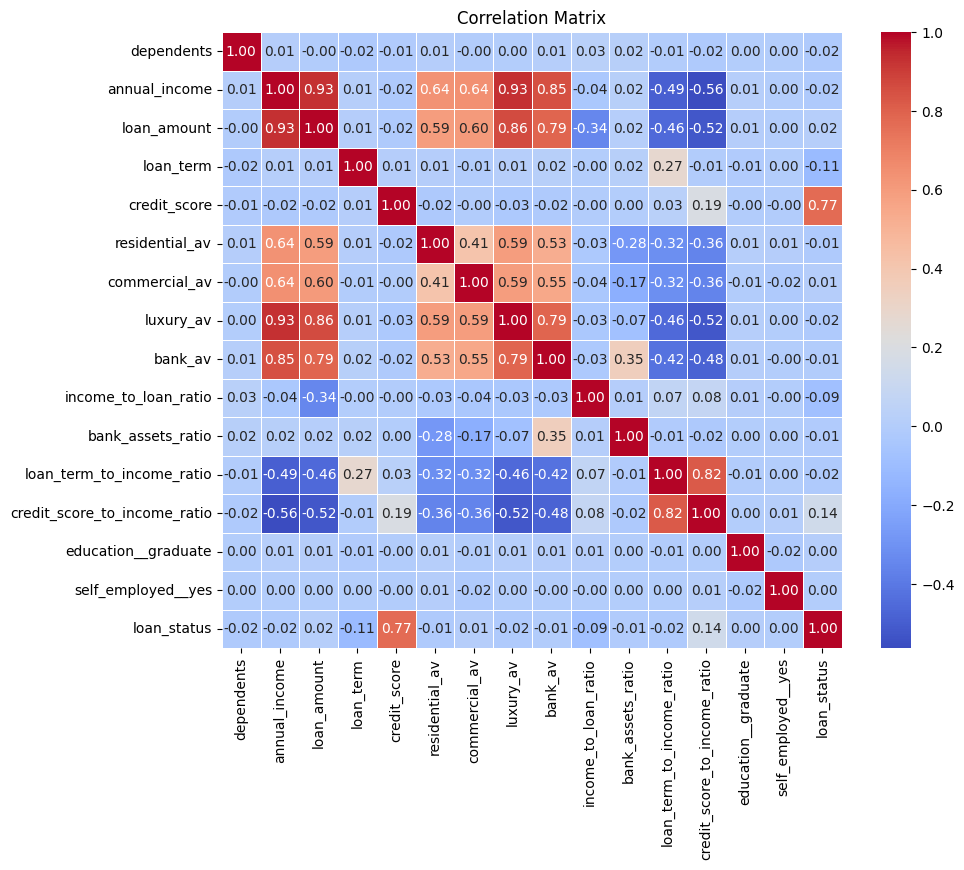

In [29]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

📌 Credit score, income to loan ratio and credit score to income ratio correlate with loan status so we keep the features associated with them

In [30]:
columns_to_keep = ['loan_term', 'annual_income', 'loan_amount', 'credit_score', 'loan_status']

In [31]:
df_filtered = df[columns_to_keep]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   loan_term      4269 non-null   int64
 1   annual_income  4269 non-null   int64
 2   loan_amount    4269 non-null   int64
 3   credit_score   4269 non-null   int64
 4   loan_status    4269 non-null   int64
dtypes: int64(5)
memory usage: 166.9 KB


In [32]:
# Creation of the derived features
df_filtered['income_loan_ratio'] = df_filtered['annual_income'] / df_filtered['loan_amount']
df_filtered['credit_score_income_ratio'] = df_filtered['credit_score'] / df_filtered['annual_income']
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_term                  4269 non-null   int64  
 1   annual_income              4269 non-null   int64  
 2   loan_amount                4269 non-null   int64  
 3   credit_score               4269 non-null   int64  
 4   loan_status                4269 non-null   int64  
 5   income_loan_ratio          4269 non-null   float64
 6   credit_score_income_ratio  4269 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 233.6 KB


C:\Users\Brian Muchai\AppData\Local\Temp\ipykernel_21196\1307743684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['income_loan_ratio'] = df_filtered['annual_income'] / df_filtered['loan_amount']
C:\Users\Brian Muchai\AppData\Local\Temp\ipykernel_21196\1307743684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['credit_score_income_ratio'] = df_filtered['credit_score'] / df_filtered['annual_income']


In [33]:
new_columns_to_keep = ['loan_term', 'credit_score', 'income_loan_ratio', 'credit_score_income_ratio', 'loan_status']

In [34]:
df_filtered = df_filtered[new_columns_to_keep]

In [35]:
df_filtered.head()

,loan_term,credit_score,income_loan_ratio,credit_score_income_ratio,loan_status
0,12,778,0.321070,0.000081,1
1,8,417,0.336066,0.000102,0
2,20,506,0.306397,0.000056,0
3,8,467,0.267101,0.000057,0
4,20,382,0.404959,0.000039,0


# Training phase

In [36]:
X = df_filtered.drop(columns=['loan_status'])  
y = df_filtered['loan_status']  

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

📌 Log transormation function

In [38]:
def log_transform(*dfs):
    transformed_dfs = []
    
    for df in dfs:
        df_copy = df.copy()
        numeric_columns = df_copy.select_dtypes(include=[np.number]).columns
        
        # Apply Log transformation to all numerical columns with positive values
        for column in numeric_columns:
            if (df_copy[column] > 0).all():  
                df_copy[column] = np.log(df_copy[column])
        transformed_dfs.append(df_copy)
    
    return transformed_dfs


In [41]:
# Performing log transformation on the  X training and test sets
X_train, X_test =  log_transform(X_train, X_test)

In [42]:
X_train

,loan_term,credit_score,income_loan_ratio,credit_score_income_ratio
2566,0.693147,6.133398,-1.363305,-8.470570
1357,2.772589,5.739793,-1.193278,-9.623280
2401,0.693147,5.726848,-0.850776,-9.499650
323,2.079442,6.778785,-0.935061,-9.288017
1677,2.484907,5.746203,-0.775591,-9.925605
...,...,...,...,...
454,2.079442,6.674561,-0.959776,-7.728736
966,2.890372,5.780744,-0.888639,-9.516372
2395,0.693147,6.654153,-1.335001,-9.240800
1361,2.302585,6.025866,-1.074515,-9.735555


## Model training and testing

1. **Logistic Model**

In [44]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [45]:
y_pred = logistic_model.predict(X_test)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       346
           1       0.90      0.95      0.93       508

    accuracy                           0.91       854
   macro avg       0.91      0.90      0.90       854
weighted avg       0.91      0.91      0.91       854



2. **Random Forest**

In [46]:
rf_model = RandomForestClassifier(random_state=48)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=48)

In [47]:
y_pred = rf_model.predict(X_test)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       346
           1       0.99      0.99      0.99       508

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854



3. **SVM Model**

In [48]:
svm_model = SVC(random_state=48)  
svm_model.fit(X_train, y_train)


SVC(random_state=48)

In [49]:
y_pred = svm_model.predict(X_test)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       346
           1       0.88      0.96      0.92       508

    accuracy                           0.90       854
   macro avg       0.91      0.89      0.89       854
weighted avg       0.90      0.90      0.90       854



4. **Gradient boosting model**

In [50]:
gb_model = GradientBoostingClassifier(random_state=48)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=48)

In [51]:
y_pred = gb_model.predict(X_test)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       346
           1       0.99      0.99      0.99       508

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854

